# BD04 - Predictive maintenance
## Casusgroep 7
### Dimitri Batchev, Dwayne Debets, Rade Grbić, Martijn Remmen en Peter Roijen
# Introductie
In dit project wordt er gekeken naar predictive maintenance. Het idee achter predictive maintenance is dat door het monitoren van apparatuur of machines met sensoren, de life (of fail) cycle gemanaged kan worden en zo uitval van machines op tijd aangepakt kan worden.
# Dataset
De gebruikte dataset bevat data van SSD's en HDD's per kwartaal, en de bijbehorende [SMART waardes](https://www.backblaze.com/blog/hard-drive-smart-stats/). 
De dataset is te vinden op [BackBlaze](https://www.backblaze.com/b2/hard-drive-test-data.html).

# Libraries
De volgende libraries worden geïmporteerd om gebruik te maken van de functionaliteiten die deze libraries aanbieden.

In [5]:
# Pandas voor data import
import pandas as pd 

import os

# Matplotlib en Seaborn voor grafieken
import seaborn as sns
import matplotlib.pyplot as plt

# Importeren dataset
De dataset wordt geïmporteerd met de Pandas library.

In [6]:
prefix = 'data/'

sources = os.listdir(prefix)[0:10]

dataset = pd.concat([pd.read_csv(f'{prefix}{source}') for source in sources])
dataset = dataset.dropna(how='all')

In [7]:
dataset.shape

(1652918, 149)

In [8]:
dataset.info()
dataset.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1652918 entries, 0 to 165034
Columns: 149 entries, date to smart_255_raw
dtypes: float64(144), int64(2), object(3)
memory usage: 1.8+ GB


,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2021-01-01,ZLW0EGC6,ST12000NM001G,12000138625024,0,83.0,213166608.0,NaN,NaN,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-01,Z305B2QN,ST4000DM000,4000787030016,0,114.0,79306032.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-01,ZLW0C6NE,ST12000NM001G,12000138625024,0,72.0,17162816.0,NaN,NaN,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-01,ZJV0XJQ3,ST12000NM0007,12000138625024,0,100.0,1102160.0,NaN,NaN,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-01,ZLW18MKT,ST14000NM001G,14000519643136,0,75.0,33233248.0,NaN,NaN,95.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data cleaning
Om de data bruikbaar te maken, moeten er enkele aanpassingen gemaakt worden.

# Verdeling modellen
Welke modellen zijn het meest in gebruik

<AxesSubplot:title={'center':'Meest voorkomende modellen (top 10)'}>

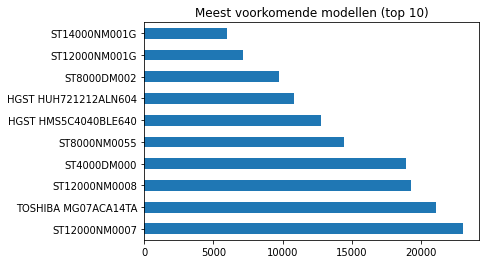

In [9]:
amount_models = dataset[['model', 'serial_number']].drop_duplicates('serial_number').model.value_counts()
amount_models.head(10).plot(kind='barh', title="Meest voorkomende modellen (top 10)")

# Failures per model

<AxesSubplot:title={'center':'Aantal failures per model (top 10)'}>

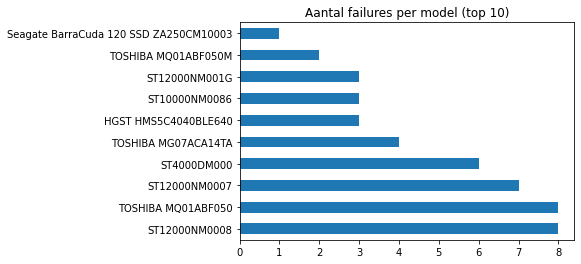

In [10]:
model_failures = dataset[['model', 'failure']][dataset.failure == 1].model.value_counts()
model_failures.head(10).plot(kind='barh', title="Aantal failures per model (top 10)")